## 0. 필요한 모듈 불러오기

In [21]:
!pip install torchsummary

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset 정의 및 dataset 로딩

In [23]:
# images = np.load(r'C:\Users\james\Desktop\U-net\Part 1\Part 1\Images\images.npy', mmap_mode='r')
# images = images.astype('int32')

# masks = np.load(r'C:\Users\james\Desktop\U-net\Part 1\Part 1\Masks\masks.npy', mmap_mode='r')
# masks = masks.astype('int32')

# print(images.shape)
# print(masks.shape)

In [24]:
class NumpySegDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None, target_transform=None):
        self.images = np.load(images_path, mmap_mode='r')
        self.masks = np.load(masks_path, mmap_mode='r')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        # image는 정규화하면 소수로 변하니까 float, mask는 정규화 안하니까 int
        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
        mask = torch.tensor(mask, dtype=torch.int64).permute(2,0,1)

        return image, mask

In [25]:
images_path='/kaggle/input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy'
masks_path= '/kaggle/input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy'

dataset = NumpySegDataset(images_path, masks_path)

In [26]:
total_len = len(dataset)
train_len = int(total_len * 0.8)
val_len = total_len - train_len

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [27]:
next(iter(train_loader))[0].shape

torch.Size([4, 3, 256, 256])

## 2. 모델 architecture 정의

In [28]:
class UNetConv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConv2, self).__init__()
        # (입력크기+2*패딩-커널크기)/스트라이드+1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(nn.Module):
    def __init__(self, num_classes=6, in_channel=3):
        # 부모 클래스 초기화되어 자식 클래스에서도 사용 가능
        super(UNet, self).__init__()
        self.conv_1 = UNetConv2(in_channel, 64)
        self.conv_2 = UNetConv2(64, 128)
        self.conv_3 = UNetConv2(128, 256)
        self.conv_4 = UNetConv2(256, 512)

        self.mid_conv = UNetConv2(512, 1024)

        self.conv_5 = UNetConv2(1024, 512)
        self.conv_6 = UNetConv2(512, 256)
        self.conv_7 = UNetConv2(256, 128)
        self.conv_8 = UNetConv2(128, 64)

        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.end = nn.Conv2d(64, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        padded_x = F.pad(x, (92, 92, 92, 92), mode='reflect')
        conv_1 = self.conv_1(padded_x) # output: 252*252
        if conv_1.size()[2] % 2 != 0:
            conv_1 = F.pad(conv_1, (0, 1, 0, 1))
        pool1 = self.down(conv_1) # output: 126*126

        conv_2 = self.conv_2(pool1) # output: 122*122
        if conv_2.size()[2] % 2 != 0:
            conv_2 = F.pad(conv_2, (0, 1, 0, 1))
        pool2 = self.down(conv_2) # output: 61*61

        conv_3 = self.conv_3(pool2) # output: 57*57
        if conv_3.size()[2] % 2 != 0:
            conv_3 = F.pad(conv_3, (0, 1, 0, 1))
        pool3 = self.down(conv_3) # output: 29*29

        conv_4 = self.conv_4(pool3) # output: 25*25
        if conv_4.size()[2] % 2 != 0:
            conv_4 = F.pad(conv_4, (0, 1, 0, 1))
        pool4 = self.down(conv_4) # output: 13*13

        mid_conv = self.mid_conv(pool4) # output: 9*9

        up_1 = self.up_1(mid_conv)
        scale_idx_1 = (conv_4.shape[2] - up_1.shape[2]) // 2
        cropped_conv_4 = conv_4[:, :, scale_idx_1:-scale_idx_1, scale_idx_1:-scale_idx_1]
        up_1 = torch.cat([up_1, cropped_conv_4], dim=1)
        conv_5 = self.conv_5(up_1)

        up_2 = self.up_2(conv_5)
        scale_idx_2 = (conv_3.shape[2] - up_2.shape[2]) // 2
        cropped_conv_3 = conv_3[:, :, scale_idx_2:-scale_idx_2, scale_idx_2:-scale_idx_2]
        up_2 = torch.cat([up_2, cropped_conv_3], dim=1)
        conv_6 = self.conv_6(up_2)

        up_3 = self.up_3(conv_6)
        scale_idx_3 = (conv_2.shape[2] - up_3.shape[2]) // 2
        cropped_conv_2 = conv_2[:, :, scale_idx_3:-scale_idx_3, scale_idx_3:-scale_idx_3]
        up_3 = torch.cat([up_3, cropped_conv_2], dim=1)
        conv_7 = self.conv_7(up_3)

        up_4 = self.up_4(conv_7)
        scale_idx_4 = (conv_1.shape[2] - up_4.shape[2]) // 2
        cropped_conv_1 = conv_1[:, :, scale_idx_4:-scale_idx_4, scale_idx_4:-scale_idx_4]
        up_4 = torch.cat([up_4, cropped_conv_1], dim=1)
        conv_8 = self.conv_8(up_4)

        end = self.end(conv_8)
        scale_idx_5 = (end.shape[2]-x.shape[2]) // 2
        end = end[:, :, scale_idx_5:-scale_idx_5, scale_idx_5:-scale_idx_5]

        return end

## 3. 손실함수와 optimizer 정의

### 3.1 model instance summary

In [29]:
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
summary(model, (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 438, 438]           1,792
       BatchNorm2d-2         [-1, 64, 438, 438]             128
              ReLU-3         [-1, 64, 438, 438]               0
            Conv2d-4         [-1, 64, 436, 436]          36,928
       BatchNorm2d-5         [-1, 64, 436, 436]             128
              ReLU-6         [-1, 64, 436, 436]               0
         UNetConv2-7         [-1, 64, 436, 436]               0
         MaxPool2d-8         [-1, 64, 218, 218]               0
            Conv2d-9        [-1, 128, 216, 216]          73,856
      BatchNorm2d-10        [-1, 128, 216, 216]             256
             ReLU-11        [-1, 128, 216, 216]               0
           Conv2d-12        [-1, 128, 214, 214]         147,584
      BatchNorm2d-13        [-1, 128, 214, 214]             256
             ReLU-14        [-1, 128, 2

### 3.2 cuda 메모리 확인

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 3.2.2 cuda 메모리 확인 함수

In [32]:
import torch

def print_cuda_memory_info():
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")

            # 직접 메모리 정보 가져오기
            free_memory, total_memory = torch.cuda.mem_get_info(i)
            free_memory = free_memory / (1024 ** 3)  # Convert to GB
            total_memory = total_memory / (1024 ** 3)  # Convert to GB

            # 할당된 메모리와 예약된 메모리 가져오기
            allocated_memory = torch.cuda.memory_allocated(i) / (1024 ** 3)  # Convert to GB
            reserved_memory = torch.cuda.memory_reserved(i) / (1024 ** 3)  # Convert to GB

            print(f"  Total memory: {total_memory:.2f} GB")
            print(f"  Free memory: {free_memory:.2f} GB")
            print(f"  Allocated memory: {allocated_memory:.2f} GB")
            print(f"  Reserved memory: {reserved_memory:.2f} GB")
    else:
        print("CUDA is not available.")

print_cuda_memory_info()

Device 0: Tesla P100-PCIE-16GB
  Total memory: 15.89 GB
  Free memory: 10.97 GB
  Allocated memory: 0.90 GB
  Reserved memory: 4.62 GB


### 3.3 weights 계산

In [33]:
def find_others(labels, i, j, k, b, d):
    left = max(i - d, 0)
    right = min(i + d, 255)  # 256이 아니라 255까지
    up = max(j - d, 0)
    down = min(j + d, 255)  # 256이 아니라 255까지
    instance = labels[b, k, i, j]

    region = labels[b, k, left:right+1, up:down+1]
    other_classes = (region == 0).sum().item()
    other_instances = ((region != 0) & (region != instance)).sum().item()

    return other_classes, other_instances

def calculate_weights(masks):
    device = masks.device
    batch_size, num_classes, height, width = masks.shape
    weights = torch.zeros((batch_size, height, width), device=device)
    non_zero_counts = (masks != 0).sum(dim=(2, 3))

    for b in range(batch_size):
        non_zero_ratio = non_zero_counts[b].float() / non_zero_counts[b].sum(dim=0, keepdim=True).float()
        exp_non_zero_ratio = torch.exp(-non_zero_ratio)
        
        for k in range(num_classes):
            mask_k = masks[b, k]
            non_zero_mask = mask_k != 0
            weights[b][non_zero_mask] = exp_non_zero_ratio[k]

            for i in range(2, height, 5):
                for j in range(2, width, 5):
                    if non_zero_mask[i, j]:
                        other_classes, other_instances = find_others(masks, i, j, k, b, 2)
                        weights[b, i-2:i+3, j-2:j+3] *= (1.02)**other_classes
                        weights[b, i-2:i+3, j-2:j+3] *= (1.05)**other_instances

    return weights

In [34]:
# all_masks = torch.tensor(np.load(masks_path, mmap_mode='r'), dtype=torch.int64).to(device)
# all_masks = all_masks.permute(0, 3, 1, 2)  # (batch_size, channels, height, width) 형태로 변환

# weights = calculate_weights(all_masks[0:500])
# torch.save(weights, 'weights.pt')
# print(weights.shape)

# del weights
# torch.cuda.empty_cache()
# weights1 = calculate_weights(all_masks[500:1000])
# torch.save(weights1, 'weights1.pt')
# print(weights1.shape)

# del weights1
# torch.cuda.empty_cache()
# weights2 = calculate_weights(all_masks[1000:1500])
# torch.save(weights2, 'weights2.pt')
# print(weights2.shape)

# del weights2
# torch.cuda.empty_cache()
# weights3 = calculate_weights(all_masks[1500:2000])
# torch.save(weights3, 'weights3.pt')
# print(weights3.shape)

# del weights3
# torch.cuda.empty_cache()
# weights4 = calculate_weights(all_masks[2000:2500])
# torch.save(weights4, 'weights4.pt')
# print(weights4.shape)

# del weights4
# torch.cuda.empty_cache()
# weights5 = calculate_weights(all_masks[2500:])
# torch.save(weights5, 'weights5.pt')
# print(weights5.shape)

In [35]:
# weights = torch.load('weights.pt')
# weights1 = torch.load('weights1.pt')
# weights2 = torch.load('weights2.pt')
# weights3 = torch.load('weights3.pt')
# weights4 = torch.load('weights4.pt')
# weights5 = torch.load('weights5.pt')

# final_weights = torch.cat((weights, weights1, weights2, weights3, weights4, weights5), dim=0)
# print(final_weights.shape)
# torch.save(final_weights, 'final_weights.pt')

In [36]:
weights = torch.load('/kaggle/input/u-net/pytorch/u-net/1/final_weights.pt')

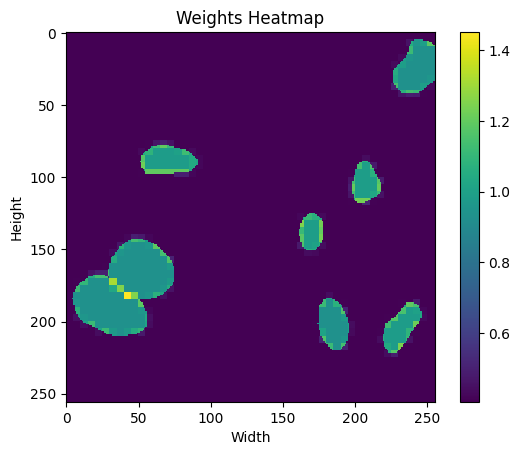

In [37]:
plt.imshow(weights[0].to('cpu'), cmap = 'viridis', interpolation='nearest')
plt.colorbar()
plt.title('Weights Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

### 3.4 custom_loss 정의

In [38]:
def custom_loss(outputs, labels, weights):
    # softmax 계산
    softmax_outputs = F.softmax(outputs, dim=1)

    # CPU로 이동
    labels = labels.cpu()
    weights = weights.cpu()
    softmax_outputs = softmax_outputs.cpu()

    # 0이 아닌 위치를 찾기 위한 마스크 생성
    non_zero_mask = labels != 0

    # 마스크를 사용하여 필요한 값 선택 및 계산
    selected_weights = weights.unsqueeze(1).expand_as(labels)[non_zero_mask]
    selected_softmax_outputs = softmax_outputs[non_zero_mask]

    # 손실 계산
    running_loss = (-1) * selected_weights * torch.log(selected_softmax_outputs)
    running_loss = running_loss.sum()

    running_loss /= labels.shape[0] * labels.shape[2] * labels.shape[3]

    return running_loss.to(outputs.device)

## 4. Train & Validation

In [39]:
print(device)
model = model.to(device)

cuda


In [40]:
num_epochs = 50  # Number of epochs
batch_size = 4
val_idx_start = len(train_loader.dataset)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0

        # Iterate over data with tqdm for the progress bar
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"{phase.capitalize()} Phase")
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)

                if phase == 'train':
                    batch_weights = weights[batch_idx * batch_size : (batch_idx + 1) * batch_size]
                else:
                    batch_weights = weights[val_idx_start + batch_idx * batch_size : val_idx_start + (batch_idx + 1) * batch_size]

                loss = custom_loss(outputs, labels, batch_weights)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(dataloader.dataset)

            # Update the progress bar with the current loss value
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        if phase == 'val':
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')
        print()

Epoch 1/50


Train Phase: 100%|██████████| 531/531 [03:05<00:00,  2.86it/s, loss=0.1574]


Val Phase: 100%|██████████| 133/133 [00:24<00:00,  5.53it/s, loss=0.1369]


Val Loss: 0.2298

Epoch 2/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1582]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.29it/s, loss=0.1808]


Val Loss: 0.2202

Epoch 3/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2158]


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.21it/s, loss=0.1282]


Val Loss: 0.2143

Epoch 4/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2614]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.24it/s, loss=0.1033]


Val Loss: 0.2074

Epoch 5/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.3640]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.24it/s, loss=0.2647]


Val Loss: 0.2051

Epoch 6/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1473]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.34it/s, loss=0.1338]


Val Loss: 0.2078

Epoch 7/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1301]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.2576]


Val Loss: 0.2136

Epoch 8/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1389]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s, loss=0.1800]


Val Loss: 0.2050

Epoch 9/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.3050]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.38it/s, loss=0.3875]


Val Loss: 0.1905

Epoch 10/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1469]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.28it/s, loss=0.3592]


Val Loss: 0.1960

Epoch 11/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.99it/s, loss=0.2218]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s, loss=0.1107]


Val Loss: 0.1986

Epoch 12/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1611]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.35it/s, loss=0.2287]


Val Loss: 0.1889

Epoch 13/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2298]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.1913]


Val Loss: 0.2045

Epoch 14/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1928]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.34it/s, loss=0.2841]


Val Loss: 0.1926

Epoch 15/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.2874]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.30it/s, loss=0.3280]


Val Loss: 0.1833

Epoch 16/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1935]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.27it/s, loss=0.2231]


Val Loss: 0.1953

Epoch 17/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.2678]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s, loss=0.2126]


Val Loss: 0.1953

Epoch 18/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1891]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.25it/s, loss=0.3172]


Val Loss: 0.1780

Epoch 19/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.0994]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.28it/s, loss=0.1809]


Val Loss: 0.1701

Epoch 20/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1696]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.35it/s, loss=0.1322]


Val Loss: 0.1716

Epoch 21/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.0725]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.31it/s, loss=0.1167]


Val Loss: 0.1651

Epoch 22/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1788]


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.22it/s, loss=0.0649]


Val Loss: 0.1699

Epoch 23/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1128]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.31it/s, loss=0.1439]


Val Loss: 0.1777

Epoch 24/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2399]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.33it/s, loss=0.1420]


Val Loss: 0.1691

Epoch 25/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2160]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.24it/s, loss=0.1436]


Val Loss: 0.1624

Epoch 26/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1278]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.0987]


Val Loss: 0.1575

Epoch 27/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.0703]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.32it/s, loss=0.1440]


Val Loss: 0.1561

Epoch 28/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2383]


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s, loss=0.0915]


Val Loss: 0.1534

Epoch 29/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1124]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.1521]


Val Loss: 0.1631

Epoch 30/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1408]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.28it/s, loss=0.0893]


Val Loss: 0.1622

Epoch 31/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.2835]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.30it/s, loss=0.1450]


Val Loss: 0.1596

Epoch 32/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1696]


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.21it/s, loss=0.1093]


Val Loss: 0.1498

Epoch 33/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.0988]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.34it/s, loss=0.1813]


Val Loss: 0.1496

Epoch 34/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.1478]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.38it/s, loss=0.1305]


Val Loss: 0.1438

Epoch 35/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.99it/s, loss=0.2288]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.30it/s, loss=0.1268]


Val Loss: 0.1494

Epoch 36/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1714]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.35it/s, loss=0.0695]


Val Loss: 0.1411

Epoch 37/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1155]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.37it/s, loss=0.1682]


Val Loss: 0.1565

Epoch 38/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1592]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.29it/s, loss=0.1189]


Val Loss: 0.1503

Epoch 39/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1830]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s, loss=0.0843]


Val Loss: 0.1458

Epoch 40/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1133]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.36it/s, loss=0.0740]


Val Loss: 0.1402

Epoch 41/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1041]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.1144]


Val Loss: 0.1351

Epoch 42/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.0937]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.39it/s, loss=0.1167]


Val Loss: 0.1522

Epoch 43/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1626]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.31it/s, loss=0.1106]


Val Loss: 0.1401

Epoch 44/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1327]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.31it/s, loss=0.1320]


Val Loss: 0.1387

Epoch 45/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.0625]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.37it/s, loss=0.1558]


Val Loss: 0.1509

Epoch 46/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1042]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.35it/s, loss=0.1192]


Val Loss: 0.1410

Epoch 47/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1350]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.26it/s, loss=0.0852]


Val Loss: 0.1531

Epoch 48/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.98it/s, loss=0.1270]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.29it/s, loss=0.1563]


Val Loss: 0.1496

Epoch 49/50


Train Phase: 100%|██████████| 531/531 [02:13<00:00,  3.97it/s, loss=0.0708]


Val Phase: 100%|██████████| 133/133 [00:12<00:00, 10.33it/s, loss=0.0934]


Val Loss: 0.1546

Epoch 50/50


Train Phase: 100%|██████████| 531/531 [02:14<00:00,  3.96it/s, loss=0.0529]


Val Phase: 100%|██████████| 133/133 [00:13<00:00, 10.13it/s, loss=0.1321]

Val Loss: 0.1571



In [41]:
torch.save(model.state_dict(), 'model.pth')

### 4.1 결과 시각화

Val_loss of 0th batch: 0.07690732181072235


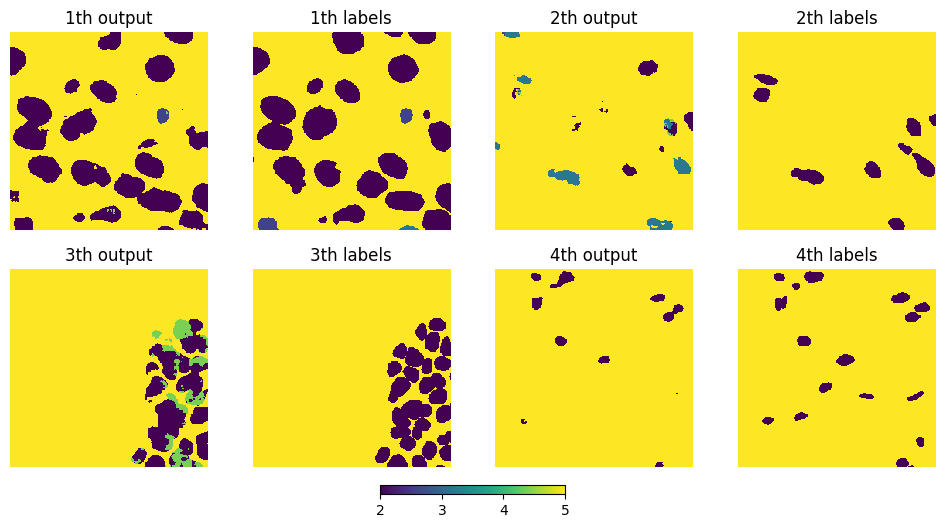

In [142]:
from itertools import islice

val_idx = 0
model.eval()   # Set model to evaluate mode
val_loss = 0.0
val_idx_start = val_idx_start = len(train_loader.dataset)

batch_weights = weights[val_idx_start + batch_idx * batch_size : val_idx_start + (batch_idx + 1) * batch_size]

with torch.no_grad():
    inputs, labels = next(islice(val_loader, val_idx, None))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    val_loss = custom_loss(outputs, labels, batch_weights).to('cpu')

print(f'Val_loss of {val_idx}th batch: {val_loss}')

max_prob_outputs, max_outputs = torch.max(outputs, dim=1)

non_zero_indices = torch.nonzero(labels)

batch_indices = non_zero_indices[:, 0]
channel_indices = non_zero_indices[:, 1]
height_indices = non_zero_indices[:, 2]
width_indices = non_zero_indices[:, 3]

results = torch.zeros_like(labels)
results[batch_indices, channel_indices, height_indices, width_indices] = channel_indices
results = torch.sum(results, dim=1)

fig, axs = plt.subplots(2,4, figsize=(12, 6))

for i in range(2):
    for j in range(4):
        if j % 2 == 0:
            im = axs[i,j].imshow(max_outputs[2*i+j//2].to('cpu'), cmap = 'viridis', interpolation='nearest')
            axs[i,j].set_title(f'{1+2*i+j//2}th output')
        else : 
            im = axs[i,j].imshow(results[2*i+j//2].to('cpu'), cmap = 'viridis', interpolation='nearest')
            axs[i,j].set_title(f'{1+2*i+j//2}th labels')
        axs[i, j].axis('off')

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

## 5. Instance Segmentation

(24, 2)


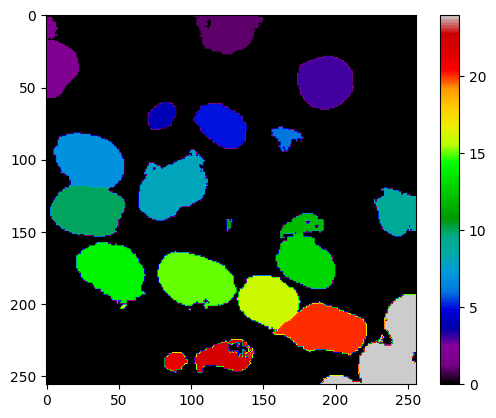

In [143]:
import cv2
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def apply_watershed(mask, threshold=0.5, min_distance=10):
    mask = (mask > threshold).astype(np.uint8)
    distance = ndimage.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, footprint=np.ones((5, 5)), labels=mask,  min_distance=min_distance)
    print(local_maxi.shape)
    x_idx = local_maxi[:,0]
    y_idx = local_maxi[:,1]
    maxi_idx = np.zeros_like(mask)
    maxi_idx[x_idx, y_idx] = 1
    markers = ndimage.label(maxi_idx)[0]
    labels = watershed(-distance, markers, mask=mask)
    return labels

# Dummy model output for demonstration
output = outputs[:, 0, :, :].cpu().numpy()  # Simulated model output

# Using the second channel as the object mask
mask = output[0]

# Apply watershed algorithm
labels = apply_watershed(mask, min_distance=20)

# Visualization
import matplotlib.pyplot as plt
plt.imshow(labels, cmap='nipy_spectral')
plt.colorbar()
plt.show()